In [ ]:
from datasets import load_dataset
import gzip
import pandas as pd
from tqdm import tqdm
import numpy as np
from collections import Counter
import multiprocessing as mp
from functools import partial
from telewrap import Telewrap

In [2]:
dataset_id = 'ag_news'

In [ ]:
dataset = load_dataset(dataset_id)

In [4]:
train_df = dataset['train'].to_pandas() 
train_df['compressed_length'] = train_df.text.apply(lambda x: len(gzip.compress(x.encode())))
test_df = dataset['test'].to_pandas() 
test_df['compressed_length'] = test_df.text.apply(lambda x: len(gzip.compress(x.encode())))

In [5]:
from collections import Counter
def predict_class(row,train_df, k_list=[5], denominator_constants=[-20]):
    labels_per_denominator = []
    
    Cx1x2 = train_df.text.apply(lambda x:len(gzip.compress(" ".join([row.text, x]).encode())))
    min_len = np.minimum(train_df.compressed_length, row.compressed_length)
    max_len = np.maximum(train_df.compressed_length, row.compressed_length)
    for num in denominator_constants:
        labels_per_k = []
        distance_from_x1 = (Cx1x2 - min_len) / (max_len + num)
        sorted_distances = np.argsort(distance_from_x1)
        for k in k_list:
            labels_per_k.append(Counter(train_df.loc[sorted_distances[:k], 'label']).most_common(1)[0][0])
        
        labels_per_denominator.append(labels_per_k)
    
    return np.array(labels_per_denominator)


In [6]:
rows = list(zip(*list(test_df.iterrows())))[1]

In [7]:
k_list=list(range(1,11))
denominator_constants = list(range(-20,21,5))
work_func = partial(predict_class, train_df=train_df, k_list=k_list, denominator_constants=denominator_constants)
with mp.Pool(mp.cpu_count()) as pool:
    preds = list(tqdm(pool.imap(work_func, rows), total=len(rows)))

100%|██████████| 7600/7600 [16:27<00:00,  7.70it/s]


In [9]:
preds = np.array(preds)
accuracies = np.zeros((len(k_list), len(denominator_constants)))
from sklearn.metrics import accuracy_score
for k_idx, k in enumerate(k_list):
    for d_idx, d in enumerate(denominator_constants):
        accuracy = accuracy_score(test_df.label, preds[:,d_idx, k_idx])
        accuracies[k_idx, d_idx] = accuracy
        print(f"Accuracy for k={k} and denominator={d} is {accuracy}")

Accuracy for k=1 and denominator=-20 is 0.8782894736842105
Accuracy for k=1 and denominator=-15 is 0.8773684210526316
Accuracy for k=1 and denominator=-10 is 0.8759210526315789
Accuracy for k=1 and denominator=-5 is 0.8757894736842106
Accuracy for k=1 and denominator=0 is 0.8755263157894737
Accuracy for k=1 and denominator=5 is 0.8760526315789474
Accuracy for k=1 and denominator=10 is 0.8743421052631579
Accuracy for k=1 and denominator=15 is 0.8747368421052631
Accuracy for k=1 and denominator=20 is 0.8742105263157894
Accuracy for k=2 and denominator=-20 is 0.8782894736842105
Accuracy for k=2 and denominator=-15 is 0.8773684210526316
Accuracy for k=2 and denominator=-10 is 0.8759210526315789
Accuracy for k=2 and denominator=-5 is 0.8757894736842106
Accuracy for k=2 and denominator=0 is 0.8755263157894737
Accuracy for k=2 and denominator=5 is 0.8760526315789474
Accuracy for k=2 and denominator=10 is 0.8743421052631579
Accuracy for k=2 and denominator=15 is 0.8747368421052631
Accuracy for

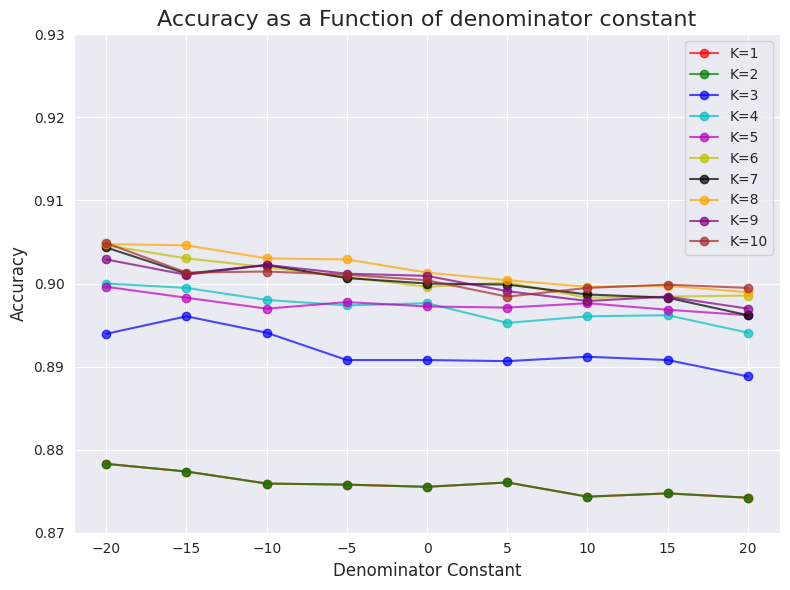

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")

# Colors for each line
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

fig, ax = plt.subplots(figsize=(8, 6))

for idx,k in enumerate(k_list):
    ax.plot(denominator_constants, accuracies[idx,:], color=colors[idx % len(colors)], label=f'K={k}', marker='o', linestyle='-', alpha=0.7)

ax.set_title("Accuracy as a Function of denominator constant", fontsize=16)
ax.set_xlabel("Denominator Constant", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_ylim(0.87, 0.93)  

ax.grid(True)
ax.legend()
plt.tight_layout() 
plt.show()


In [11]:
k_list=list(range(1,11))
denominator_constants = list(range(20,201,20))
work_func = partial(predict_class, train_df=train_df, k_list=k_list, denominator_constants=denominator_constants)
with mp.Pool(mp.cpu_count()) as pool:
    preds = list(tqdm(pool.imap(work_func, rows), total=len(rows)))

100%|██████████| 7600/7600 [18:00<00:00,  7.04it/s]


In [15]:
preds = np.array(preds)
accuracies = np.zeros((len(k_list), len(denominator_constants)))
from sklearn.metrics import accuracy_score
for k_idx, k in enumerate(k_list):
    for d_idx, d in enumerate(denominator_constants):
        accuracy = accuracy_score(test_df.label, preds[:,d_idx, k_idx])
        accuracies[k_idx, d_idx] = accuracy
        print(f"Accuracy for k={k} and denominator={d} is {accuracy}")

Accuracy for k=1 and denominator=20 is 0.8742105263157894
Accuracy for k=1 and denominator=40 is 0.8731578947368421
Accuracy for k=1 and denominator=60 is 0.8740789473684211
Accuracy for k=1 and denominator=80 is 0.8725
Accuracy for k=1 and denominator=100 is 0.8713157894736843
Accuracy for k=1 and denominator=120 is 0.8694736842105263
Accuracy for k=1 and denominator=140 is 0.8682894736842105
Accuracy for k=1 and denominator=160 is 0.8694736842105263
Accuracy for k=1 and denominator=180 is 0.8689473684210526
Accuracy for k=1 and denominator=200 is 0.8678947368421053
Accuracy for k=2 and denominator=20 is 0.8742105263157894
Accuracy for k=2 and denominator=40 is 0.8731578947368421
Accuracy for k=2 and denominator=60 is 0.8740789473684211
Accuracy for k=2 and denominator=80 is 0.8725
Accuracy for k=2 and denominator=100 is 0.8713157894736843
Accuracy for k=2 and denominator=120 is 0.8694736842105263
Accuracy for k=2 and denominator=140 is 0.8682894736842105
Accuracy for k=2 and denomina

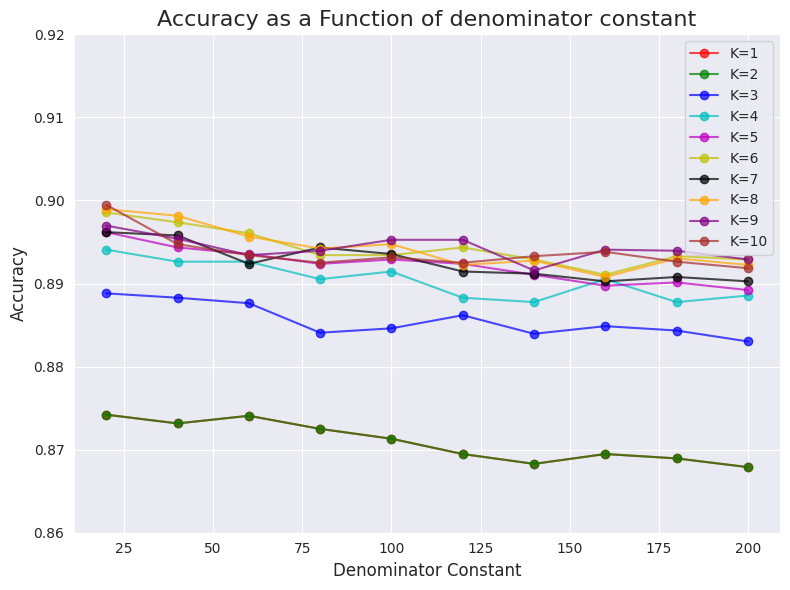

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")

# Colors for each line
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

fig, ax = plt.subplots(figsize=(8, 6))

for idx,k in enumerate(k_list):
    ax.plot(denominator_constants, accuracies[idx,:], color=colors[idx % len(colors)], label=f'K={k}', marker='o', linestyle='-', alpha=0.7)

ax.set_title("Accuracy as a Function of denominator constant", fontsize=16)
ax.set_xlabel("Denominator Constant", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_ylim(0.86, 0.92)  

ax.grid(True)
ax.legend()
plt.tight_layout() 
plt.show()